In [1]:
import sbi
from sbi.inference import SNLE, SNRE, SNPE
import torch



import jax
import jax.numpy as jnp

import numpy as np

import matplotlib.pyplot as plt 
import optax

from markovsbi.tasks import get_task
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn


data_store = []


In [173]:
data_store_local = []
dim = 10
key_number = 4



key = jax.random.PRNGKey(key_number)
task = get_task("simple{}dnonstationary".format(dim))
prior = task.get_prior()
simulator = task.get_simulator()

In [174]:
data = task.get_data(key, 10_00, 10, max_T = 1000)

In [175]:
from numpy import indices




prior_torch = torch.distributions.Independent(torch.distributions.Normal(torch.zeros(1), torch.ones(1)),1)

class EmbeddingNet(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, num_layers=2):
        super(EmbeddingNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gru = torch.nn.GRU(self.input_dim, self.output_dim, num_layers=num_layers,batch_first=True)
    
    def forward(self, x):
        *batch_shape, n_samples, n_dim = x.shape
        x = x.view(-1, n_samples, n_dim)
        # Replace nans with zeros
        mask = torch.isnan(x).any(-1, keepdim=True).to(torch.int32)
        indices = torch.argmax(mask, dim=1).squeeze(1) - 1
        x = torch.nan_to_num(x, nan=0.0)
        hs = self.gru(x)[0]   
        print(hs.shape)
        x = hs[torch.arange(hs.shape[0]), indices, :]
        print(x.shape)
        x = x.view(*batch_shape, self.output_dim)
        return x
    
inf = SNPE(prior_torch, density_estimator=sbi.utils.posterior_nn(model='nsf', embedding_net=EmbeddingNet(dim, 50), z_score_x="none"))
thetas = torch.tensor(np.array(data["thetas"]), dtype=torch.float32)
xs = torch.tensor(np.array(data["xs"]), dtype=torch.float32)

xs2 = xs.clone()

xs2[:, 2:] = torch.nan 
xs = torch.cat([xs, xs2], dim=0)
thetas = torch.cat([thetas, thetas], dim=0)




inf.append_simulations(thetas, xs, exclude_invalid_x=False)
density_estimator = inf.train(training_batch_size=1000)

/var/folders/wt/2fn1yjbn3rd4mbn_1xf9746w0000gn/T/ipykernel_95325/3588994431.py:30: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inf = SNPE(prior_torch, density_estimator=sbi.utils.posterior_nn(model='nsf', embedding_net=EmbeddingNet(dim, 50), z_score_x="none"))


torch.Size([1, 18, 50])
torch.Size([1, 50])
torch.Size([2, 18, 50])
torch.Size([2, 50])
torch.Size([1000, 18, 50])
torch.Size([1000, 50])
torch.Size([200, 18, 50])
torch.Size([200, 50])
 Training neural network. Epochs trained: 1torch.Size([1000, 18, 50])
torch.Size([1000, 50])
torch.Size([200, 18, 50])
torch.Size([200, 50])
 Training neural network. Epochs trained: 2torch.Size([1000, 18, 50])
torch.Size([1000, 50])
torch.Size([200, 18, 50])
torch.Size([200, 50])
 Training neural network. Epochs trained: 3torch.Size([1000, 18, 50])
torch.Size([1000, 50])
torch.Size([200, 18, 50])
torch.Size([200, 50])
 Training neural network. Epochs trained: 4torch.Size([1000, 18, 50])
torch.Size([1000, 50])
torch.Size([200, 18, 50])
torch.Size([200, 50])
 Training neural network. Epochs trained: 5torch.Size([1000, 18, 50])
torch.Size([1000, 50])
torch.Size([200, 18, 50])
torch.Size([200, 50])
 Training neural network. Epochs trained: 6torch.Size([1000, 18, 50])
torch.Size([1000, 50])
torch.Size([200,

In [176]:
posterior = inf.build_posterior()

In [187]:

theta_o = prior.sample(key)
num_obs = 2
x_o = np.array(simulator(key, theta_o, num_obs))




In [188]:


x_o = torch.tensor(np.array(x_o))
posterior._x_shape = (1, x_o.shape[0], x_o.shape[1])
posterior.posterior_estimator._condition_shape = x_o.shape
samples = posterior.sample((1000,), x=x_o, show_progress_bars=False)



#samples = posterior.sample((1000,),  x=x_o)

input_x_shape: torch.Size([2, 10])
x_event_shape: None
torch.Size([1, 2, 50])
torch.Size([1, 50])


/opt/anaconda3/lib/python3.11/site-packages/sbi/utils/user_input_checks.py:587: UserWarning: An x with a batch size of 2 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


In [189]:
import torch
import numpy as np

true_posterior = task.get_true_posterior(jnp.array(x_o))
true_samples = true_posterior.sample(jax.random.PRNGKey(1), (1000,))   
true_samples = torch.tensor(np.array(true_samples)) 

print(true_samples.shape)


from sbi.utils.metrics import c2st 

distance = c2st(torch.tensor(np.array(samples))[:1000], true_samples[:1000])

10
(1, 10)
(1, 10)
torch.Size([1000, 10])


x_o: torch.Size([2, 10])
10
(1, 10)
(1, 10)
true_posterior: <markovsbi.utils.prior_utils.Normal object at 0x2fb4f4390>
l: (100,)
logpdf: (100,)
jnp.exp(logpdf): (100,)


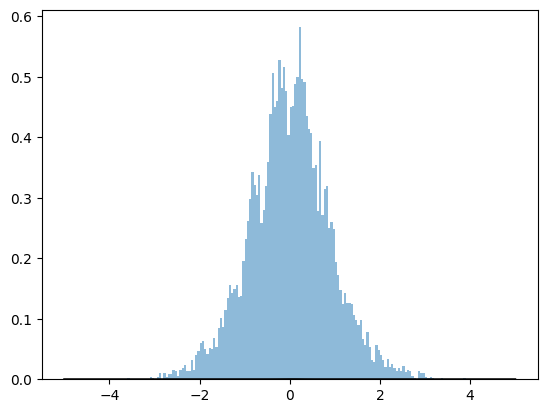

In [190]:

print('x_o:', x_o.shape)
true_posterior = task.get_true_posterior(jnp.array(x_o))


print('true_posterior:', true_posterior)
l = jnp.linspace(-5, 5, 100)
logpdf = true_posterior.log_prob(l.reshape(-1,1))

print('l:', l.shape)
print('logpdf:', logpdf.shape)
print('jnp.exp(logpdf):', jnp.exp(logpdf).shape)


plt.hist(samples.flatten(), bins=200, density=True, range=(-5,5), alpha=0.5)
plt.plot(l, jnp.exp(logpdf), color="black")
plt.vlines(theta_o, 0, jnp.exp(true_posterior.log_prob(theta_o)), color="red")

In [191]:

data_store_local = []


data_store_local.append(dim)
data_store_local.append(key_number)
data_store_local.append(num_obs)
data_store_local.append(distance)

data_store.append(np.array(data_store_local))
#print(data_store_local)

#print(data_store)



import pandas as pd

sample = pd.DataFrame(data_store, columns=['dim', 'key_number', 'obs_length','C2ST'])
print(sample)
sample.to_csv('Nonstationary_{}_10_2k.csv'.format("NPE"))

     dim  key_number  obs_length    C2ST
0    2.0         0.0       101.0  0.9125
1    2.0         0.0        11.0  0.6755
2    2.0         0.0         2.0  0.6050
3    2.0         1.0       101.0  0.9105
4    2.0         1.0        11.0  0.7320
5    2.0         1.0         2.0  0.7345
6    2.0         2.0       101.0  0.7740
7    2.0         2.0        11.0  0.7800
8    2.0         2.0         2.0  0.6320
9    2.0         3.0       101.0  0.9875
10   2.0         3.0        11.0  0.6515
11   2.0         3.0         2.0  0.5765
12   2.0         4.0         2.0  0.5915
13   2.0         4.0        11.0  0.6290
14   2.0         4.0       101.0  0.8245
15  10.0         0.0       101.0  0.9935
16  10.0         0.0        11.0  0.9725
17  10.0         0.0         2.0  0.8920
18  10.0         1.0       101.0  0.9975
19  10.0         1.0        11.0  0.9590
20  10.0         1.0         2.0  0.8750
21  10.0         2.0       101.0  0.9955
22  10.0         2.0        11.0  0.9580
23  10.0        